# Extended DMD with control for nonlinear systems
We demonstrate extended dynamic mode decomposition for control (EDMDc) applied to the classical forced Van der Pol oscillator
(this is example in Sec. 4 in Korda & Mezić, _"Linear predictors for nonlinear dynamical systems: Koopman operator meets model predictive control"_, Automatica 2018), with dynamics given by:

$$\dot{x}_{1} = 2x_2 u,\\
\dot{x}_2 = -0.8x_1 + 2x_2 -10x_1^2x_2 + u$$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

import pykoopman as pk

Generating training data, where each trajectory starts at a random initial condition in the unit box $[-1,1]^2$ and is forced by a random control signal with values drawn from a uniform distribution over the interval $[-1,1]$.

In [2]:
n_states = 2 # Number of states
n_inputs = 1 # Number of control inputs
dT = 0.01    # Timestep

from pykoopman.common.examples import vdp_osc, rk4, square_wave

# Integrate
# def integrate_vdp(x0, u, dT, n_int):
#     n_states, = x0.size
#     n_inputs, = u.size
#     X = np.zeros((n_states, n_int))
#     X[:, 0] = x0
#     x = x0.reshape(n_states,1)
#     U = np.zeros(n_inputs, n_int)
#     for step in range(n_int-1):
#         y = rk4(0, x, u[np.newaxis, step], dT, vdp_osc)
#         X[:, step+1] = y.reshape(n_states,)
#         U[:, step] = u[step]
#         x = y
#     return X, U

A training dataset is created consisting of 200 trajectories, each trajectory is integrated for 1000 timesteps and forced by a random actuation in the range $[-1,1]$.

In [3]:
n_traj = 200  # Number of trajectories
n_int = 1000  # Integration length
t = np.arange(0, n_int*dT, dT)

# Uniform forcing in [-1, 1]
u = 2*rnd.rand(n_int, n_traj)-1

# Uniform distribution of initial conditions
x = 2*rnd.rand(n_states, n_traj)-1

# Init
X = np.zeros((n_states, n_int*n_traj))
Y = np.zeros((n_states, n_int*n_traj))
U = np.zeros((n_inputs, n_int*n_traj))

# Integrate
for step in range(n_int):
    y = rk4(0, x, u[step, :], dT, vdp_osc)
    X[:, (step)*n_traj:(step+1)*n_traj] = x
    Y[:, (step)*n_traj:(step+1)*n_traj] = y
    U[:, (step)*n_traj:(step+1)*n_traj] = u[step, :]
    x = y

t = np.arange(0, n_int*dT, dT)

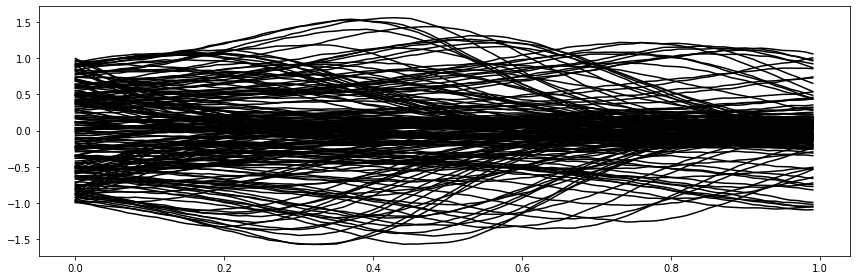

In [4]:
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 4))
for traj_idx in range(n_traj):
    x = X[:, traj_idx::n_traj]
    axs.plot(t[0:100], x[1, 0:100], 'k')

In [5]:
import pykoopman as pk
EDMDc = pk.regression.EDMDc()
RBF = pk.observables.RadialBasisFunction(rbf_type='gauss', n_centers=10, centers=None, kernel_width=1.0, polyharmonic_coeff=1.0)

print(type(EDMDc))
model = pk.Koopman(observables=RBF, regressor=EDMDc)
model.fit(x=X.T, u=U.T)

<class 'pykoopman.regression._edmdc.EDMDc'>


Koopman(observables=RadialBasisFunction(centers=array([[-0.24959736, -1.02471664, -1.13125413, -0.43153861, -0.76754139,
         0.7605929 ,  0.67189065,  1.11180327,  0.34607824, -0.57745373],
       [ 0.01486866,  1.22924233, -1.57241881,  0.13940668,  1.55694409,
        -1.05003452, -0.21775095,  0.1004806 ,  1.03602313,  1.50709946]])),
        regressor=EDMDc())

In [6]:
Xlift = RBF.transform(X.T)
print(np.linalg.norm((model.measurement_matrix() @ Xlift.T)-X)) # check inverse / measurement matrix

1.3820418180011762e-12


(300, 2)


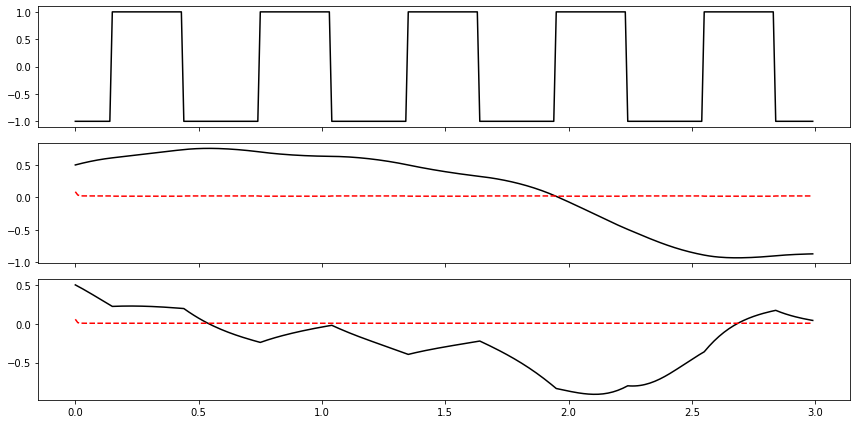

In [7]:
n_int = 300  # Integration length
t = np.arange(0, n_int*dT, dT)
u = np.array([-square_wave(step+1) for step in range(n_int)])
# u = np.zeros((1, n_int)) #2*rnd.rand(1, n_int)-1
x = np.array([0.5, 0.5])
# x = np.array([[-0.1], [-0.5]])

# Integrate nonlinear system
Xtrue = np.zeros((n_states, n_int))
Xtrue[:, 0] = x
for step in range(1, n_int, 1):
    y = rk4(0, Xtrue[:, step-1].reshape(n_states,1), u[np.newaxis, step-1], dT, vdp_osc)
    Xtrue[:, step] = y.reshape(n_states,)

# Predict with EDMDc model

Xkoop = model.simulate(x[np.newaxis,:], u[:, np.newaxis], n_steps=n_int)

print(Xkoop.shape)

fig, axs = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(12, 6))
#sharey=True, gridspec_kw={'width_ratios': [2, 1]}
axs[0].plot(t, u, '-k')
# axs[0, 1].hist(u, bins=20, orientation="horizontal")
axs[1].plot(t, Xtrue[0, :], '-k')
axs[1].plot(t, Xkoop[:, 0], '--r')
axs[2].plot(t, Xtrue[1, :], '-k')
axs[2].plot(t, Xkoop[:, 1], '--r')

In [8]:
# Xlift = RBF.transform(X.T)
# Ylift = RBF.transform(Y.T)
# #
# Nlift = Xlift.shape[1]
# W = np.vstack([Ylift.T, X])
# V = np.vstack([Xlift.T, U])
# VVt = V @ V.T
# WVt = W @ V.T
# M = WVt @ np.linalg.pinv(VVt)  # Matrix [A B; C 0]
# Alift = M[0:Nlift, 0:Nlift]
# Blift = M[0:Nlift, Nlift:]
# Clift = M[Nlift:, 0:Nlift]
#
# W = Ylift.T
# V = np.vstack([Xlift.T, U])
# VVt = V @ V.T
# WVt = W @ V.T #Ylift.T @ Xlift
# M = WVt @ np.linalg.pinv(VVt)  # Matrix [A B]
#
# Alift2 = M[0:Nlift, 0:Nlift]
# Blift2 = M[0:Nlift, Nlift:]
# Clift2 = X @ np.linalg.pinv(Xlift.T)
# #
# print(np.allclose(Alift, Alift2))
# print(np.allclose(Blift, Blift2))
# print(np.allclose(Clift, Clift2))
# # from pykoopman.common.examples import advance_linear_system
#
# # advance_linear_system(x0, u, n, A=Alift, B=Blift, C=Clift)
# xkoop = Clift @ Xlift.T
# xkoop2 = Clift2 @ Xlift.T
#
# # model = pk.Koopman(observables=RBF, regressor=EDMDc)
# # model.fit(x=X, y=Y, u=U)
# fig, axs = plt.subplots(1, 4, sharey=True, sharex=True, tight_layout=True, figsize=(15, 6))
# diffh0 = axs[0].matshow(Alift)
# fig.colorbar(diffh0, ax=axs[0])
# diffh1 = axs[1].matshow(Alift2)
# fig.colorbar(diffh1, ax=axs[1])
# diffh = axs[2].matshow(Alift-Alift2)
# fig.colorbar(diffh, ax=axs[2])
# diffh3 = axs[3].matshow(model.koopman_matrix)
# fig.colorbar(diffh3, ax=axs[3])
#
# print(Alift[1, 10], Alift2[1, 10])
# fig, axs = plt.subplots(2, 1, sharey=True, sharex=True, tight_layout=True, figsize=(15, 6))
# nplot = 100
# nvar = 0
# axs[0].plot(X[nvar,:nplot],'-k')
# axs[0].plot(xkoop[nvar, :nplot], '--b')
# axs[0].plot(xkoop2[nvar, :nplot], '.r')
#
# axs[1].plot(abs(xkoop[nvar, :nplot]-X[nvar,:nplot]), '-b')
# axs[1].plot(abs(xkoop2[nvar, :nplot]-X[nvar,:nplot]), '--r')
#
# print(np.linalg.norm(xkoop-X), np.linalg.norm(xkoop2-X))